In [4]:
from matplotlib.pylab import *
from scipy.optimize import *
from scipy.spatial.transform import Rotation
import numpy as np

In [14]:
# def obj_fun(pars,x,src):
#     theta, tx, ty = pars
#     H = array([[cos(theta), -sin(theta), tx],\
#          [sin(theta), cos(theta), ty],
#          [0,0,1]])
#     src1 = c_[src,ones(src.shape[0])]
#     return sum( (x - src1.dot(H.T)[:,:2])**2 )

# def apply_transform(pars, src):
#     theta, tx, ty = pars
#     H = array([[cos(theta), -sin(theta), tx],\
#          [sin(theta), cos(theta), ty],
#          [0,0,1]])
#     src1 = c_[src,ones(src.shape[0])]
#     return src1.dot(H.T)[:,:2]

In [11]:
n = 100
dst = np.random.normal(0, 1, (3, n))
r = Rotation.from_euler("xyz", [0, 45, 0], degrees=True)
src  = r.apply(dst.T).T
print(dst.shape)
print(src.shape)

(3, 100)
(3, 100)


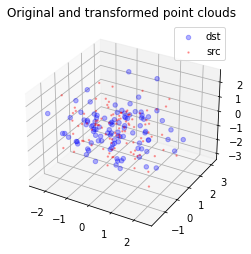

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Original and transformed point clouds")

ax.scatter(dst.T[:, 1], dst.T[:, 0], dst.T[:, 2], c="b", alpha=0.3, label="dst")
ax.scatter(src.T[:, 1], src.T[:, 0], src.T[:, 2], c="r", s=2., alpha=0.3, label="src")
ax.legend()
plt.show()

In [12]:
np.linalg.norm(src - dst, axis=0).shape

(100,)

In [20]:
def obj_fun_rot_only(parameters, dst, src):
    """
    Let's just see if this api works for rotation only for now
    """

    r = Rotation.from_euler("xyz", parameters, degrees=True)
    est = r.apply(src.T).T
    error = np.linalg.norm(est - dst, axis=0).sum()
    return error

In [21]:
res = minimize(obj_fun_rot_only, [0,0,0], args=(dst, src), method='Nelder-Mead')

In [25]:
euler_angles = res.x
r_inv_hat = Rotation.from_euler("xyz", euler_angles)
est = r_inv_hat.apply(src.T).T

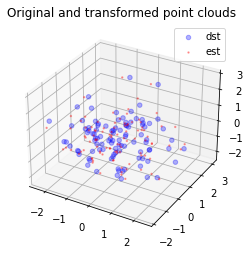

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Original and transformed point clouds")

ax.scatter(dst.T[:, 1], dst.T[:, 0], dst.T[:, 2], c="b", alpha=0.3, label="dst")
ax.scatter(est.T[:, 1], est.T[:, 0], est.T[:, 2], c="r", s=2., alpha=0.3, label="est")
# ax.scatter(src.T[:, 1], src.T[:, 0], src.T[:, 2], c="r", s=2., alpha=0.3, label="src")
ax.legend()
plt.show()

In [28]:
r.as_euler("xyz", degrees=True) + euler_angles

array([ 3.38481641e-05, -1.39590171e-05,  1.58714120e-05])

In [40]:
from poisson_modelnet_40 import get_single_modelnet40_sample, get_transform, modelnet40_to_poisson_surface, mesh_to_implicit
from tbp.monty.frameworks.environment_utils.transforms import RandomRotate
import open3d as o3d
import copy

In [37]:
n_train_samples = 1024
model_net_sample = get_single_modelnet40_sample(idx=6)
train_transform = get_transform(n_train_samples)
x_train = train_transform(copy.deepcopy(model_net_sample))
x_eval = RandomRotate()(x_train)


In [38]:
mesh = modelnet40_to_poisson_surface(x_train)

[Open3D DEBUG] Input Points / Samples: 1024 / 1023
[Open3D DEBUG] #   Got kernel density: 0.00769806 (s), 482.727 (MB) / 482.727 (MB) / 482 (MB)
[Open3D DEBUG] #     Got normal field: 0.00387788 (s), 484.398 (MB) / 484.398 (MB) / 484 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.207890e-03 / 1.236879e+00
[Open3D DEBUG] #       Finalized tree: 0.0132749 (s), 485.141 (MB) / 485.141 (MB) / 485 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0268409 (s), 485.246 (MB) / 485.246 (MB) / 485 (MB)
[Open3D DEBUG] #Set point constraints: 0.00274205 (s), 485.363 (MB) / 485.363 (MB) / 485 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 125931 / 73608 / 70313
[Open3D DEBUG] Memory Usage: 485.363 MB
Cycle[0] Depth[0/9]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(485.449 MB)	Nodes: 8
CG: 4.9741e-01 -> 4.9741e-01 -> 4.3037e-04 (8.7e-04) [32667]
[Open3D DEBUG] # Linear system solved: 0.0949001 (s), 485.605 (MB) / 485.605 (MB) / 485 (MB)
[Open3D DEBUG] Got a

In [41]:
def compute_signed_dist(scene, query):
    """
    Given an open3d scene (output of mesh_to_implicit) and a query point ([,3] tensor)
    measure 3 types of distances and return in a single array.
    """
    typed_query = o3d.core.Tensor([query.numpy()], dtype=o3d.core.Dtype.Float32)
    signed_distance = scene.compute_signed_distance(typed_query)
    return signed_distance

In [44]:
def distance_obj_fn(parameters, reconstructed_mesh, src):

    euler_angles = parameters[:3]
    translation = parameters[3:]
    r = Rotation.from_euler("xyz", euler_angles, degrees=True)
    est = r.apply(src.T).T + translation

    # 3 dims are unsigned, signed, occupancy
    n_points = est.size()[0]
    estimated_distances = np.zeros(n_points)
    scene = mesh_to_implicit(reconstructed_mesh)
    for i in range(n_points):
        query = est[i, :]
        estimated_distances[i] = compute_signed_dist(scene, query)

    return np.sum(estimated_distances ** 2)

In [48]:
idx = 0

In [49]:
for i in range(idx + 1):
    print(i)

0


In [50]:
x = np.random.normal(0, 1, 3)
print(x[:3])

[-0.98443654  0.20915999  1.63548277]
